# Using data on vehicle flow and traffic volume, a system can be built to predict congestion in specific areas. This system can serve as a tool for decision-makers to adjust traffic signal timing or suggest alternative routes to alleviate congestion.  

# Import required libraries  

In [1]:
import pandas as pd  
import numpy as np  
from datetime import datetime  
import matplotlib.pyplot as plt  
import seaborn as sns  

 # Machine learning libraries  

In [3]:
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  
from sklearn.linear_model import LinearRegression, Ridge, Lasso  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
import xgboost as xgb  


 # Set plot style and fonts  

In [7]:
plt.style.use('default')  
plt.rcParams['font.family'] = ['Inter']  
plt.rcParams['font.sans-serif'] = ['Inter']  

 # Data Loading and Cleaning  
 

 # Read the CSV file  

In [17]:
 df = pd.read_csv(r'C:\Users\owner\Desktop\Metro_Interstate_Traffic_Volume.csv',encoding='utf-8')  

 # Convert date_time column to datetime (using dayfirst=True, and errors coerce)  

In [26]:
df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True, errors='coerce')  
nat_count = df['date_time'].isna().sum()  
print("Number of NaT in date_time:", nat_count)  
if nat_count > 0:  
     df = df.dropna(subset=['date_time'])  
     print("Dropped rows with invalid date_time")  


Number of NaT in date_time: 0


 # Feature Engineering  

# Extract datetime based features: hour, day of week, month, year and weekend indicator  

In [30]:
df['hour'] = df['date_time'].dt.hour  
df['day_of_week'] = df['date_time'].dt.dayofweek  
df['month'] = df['date_time'].dt.month  
df['year'] = df['date_time'].dt.year  
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)  

 # Clean holiday column: fill missing values and create a binary indicator for holidays  

In [33]:
df['holiday'] = df['holiday'].fillna('None')  
df['is_holiday'] = (df['holiday'] != 'None').astype(int)  

# Convert temperature from Kelvin to Celsius  

In [36]:
 df['temp_celsius'] = df['temp'] - 273.15  

# Simplify weather categories using a mapping  

In [39]:
weather_mapping = {  
     'Clear': 'Clear',  
     'Clouds': 'Clouds',  
     'Rain': 'Rain',  
     'Snow': 'Snow',  
     'Drizzle': 'Rain',  
     'Mist': 'Other',  
     'Fog': 'Other',  
     'Thunderstorm': 'Storm',  
     'Haze': 'Other',  
     'Smoke': 'Other',  
     'Squall': 'Storm'  
 }  
df['weather_category'] = df['weather_main'].map(weather_mapping)  


# Create cyclic features for hour, month, and day of the week:  

In [42]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)  
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)  
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)  
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)  

# Display a sample of engineered features to verify  

In [45]:
print("\nSample of engineered features:")  
print(df[['date_time', 'hour', 'day_of_week', 'is_weekend', 'is_holiday', 'temp_celsius', 'weather_category']].head())  



Sample of engineered features:
            date_time  hour  day_of_week  is_weekend  is_holiday  \
0 2012-10-02 09:00:00     9            1           0           0   
1 2012-10-02 10:00:00    10            1           0           0   
2 2012-10-02 11:00:00    11            1           0           0   
3 2012-10-02 12:00:00    12            1           0           0   
4 2012-10-02 13:00:00    13            1           0           0   

   temp_celsius weather_category  
0         15.13           Clouds  
1         16.21           Clouds  
2         16.43           Clouds  
3         16.98           Clouds  
4         17.99           Clouds  


 # Exploratory Visualization  

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

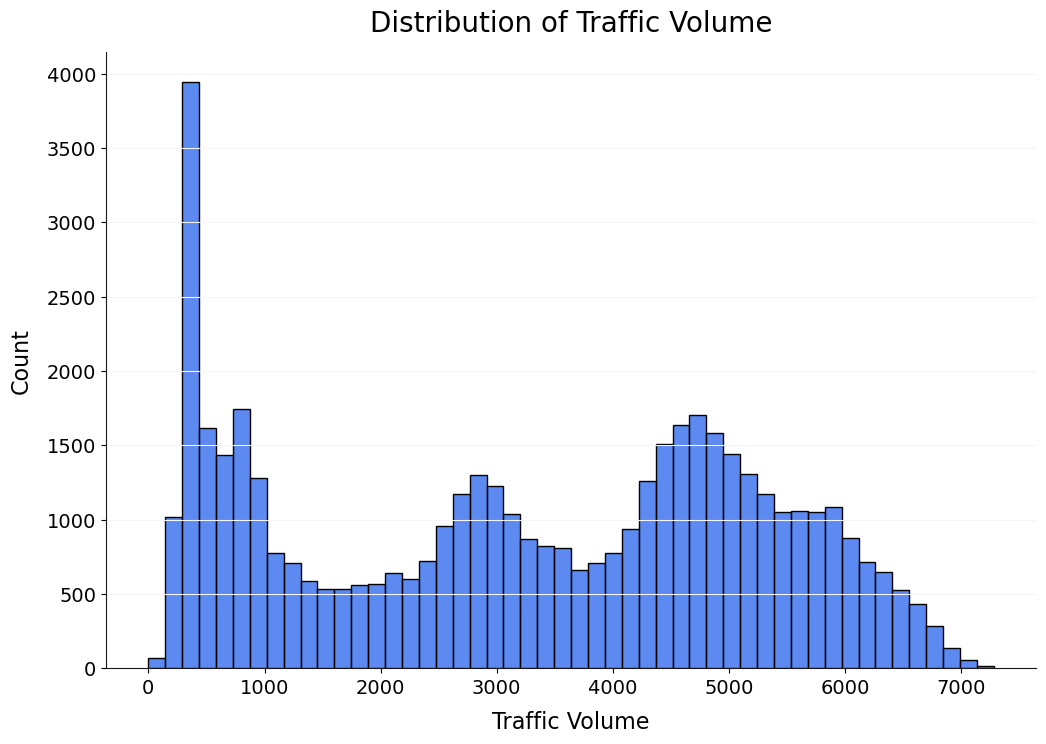

In [58]:
plt.figure(figsize=(12, 8))  
sns.histplot(data=df, x='traffic_volume', bins=50, color='#2563EB')  
plt.title('Distribution of Traffic Volume', fontsize=20, pad=15)  
plt.xlabel('Traffic Volume', fontsize=16, labelpad=10)  
plt.ylabel('Count', fontsize=16, labelpad=10)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.grid(axis='y', color='#F3F4F6')  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.gca().spines['left'].set_color('#171717')  
plt.gca().spines['bottom'].set_color('#171717')  
plt.show()  

 # Model Building and Comparison  

# Selected numeric and categorical features  

In [62]:
numeric_features = ['temp_celsius', 'rain_1h', 'snow_1h', 'clouds_all',   
                     'hour_sin', 'hour_cos', 'month_sin', 'month_cos',   
                     'day_of_week_sin', 'day_of_week_cos']  
categorical_features = ['weather_category', 'is_holiday', 'is_weekend']  


 # Separate features from target  

In [65]:
 X = df[numeric_features + categorical_features]  
 y = df['traffic_volume']  

# Split the dataset  

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Preprocessing pipelines for numeric and categorical data  

In [73]:
numeric_transformer = StandardScaler()  
categorical_transformer = OneHotEncoder(drop='first')  
   
preprocessor = ColumnTransformer(  
     transformers=[  
         ('num', numeric_transformer, numeric_features),  
         ('cat', categorical_transformer, categorical_features)  
     ]  
 )  


# Define models to compare  

In [76]:
 models = {  
     'Linear Regression': LinearRegression(),  
     'Ridge': Ridge(alpha=1.0),  
     'Lasso': Lasso(alpha=1.0),  
     'Decision Tree': DecisionTreeRegressor(random_state=42),  
     'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),  
     'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),  
     'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)  
 } 

 # Dictionary to store the results  

In [79]:
 results = {}  

# Loop through models, create pipeline, train, predict, and store metrics.  

In [82]:
for name, model in models.items():  
     print("Training " + name + "...")  
     pipeline = Pipeline([  
         ('preprocessor', preprocessor),  
         ('regressor', model)  
     ])  
     pipeline.fit(X_train, y_train)  
     y_pred = pipeline.predict(X_test)  
       
     mse = mean_squared_error(y_test, y_pred)  
     rmse = np.sqrt(mse)  
     mae = mean_absolute_error(y_test, y_pred)  
     r2 = r2_score(y_test, y_pred)  
       
     results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}  


Training Linear Regression...
Training Ridge...
Training Lasso...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...


 # Create a DataFrame with results  

In [85]:
 results_df = pd.DataFrame(results).T  
 print("\nModel Comparison Results:")  
 print(results_df.round(2))  


Model Comparison Results:
                      RMSE     MAE    R2
Linear Regression  1076.04  837.49  0.71
Ridge              1076.04  837.48  0.71
Lasso              1076.15  837.74  0.71
Decision Tree       592.62  297.48  0.91
Random Forest       443.83  245.24  0.95
Gradient Boosting   497.25  310.61  0.94
XGBoost             425.12  248.76  0.95


 # Plot model comparison  

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

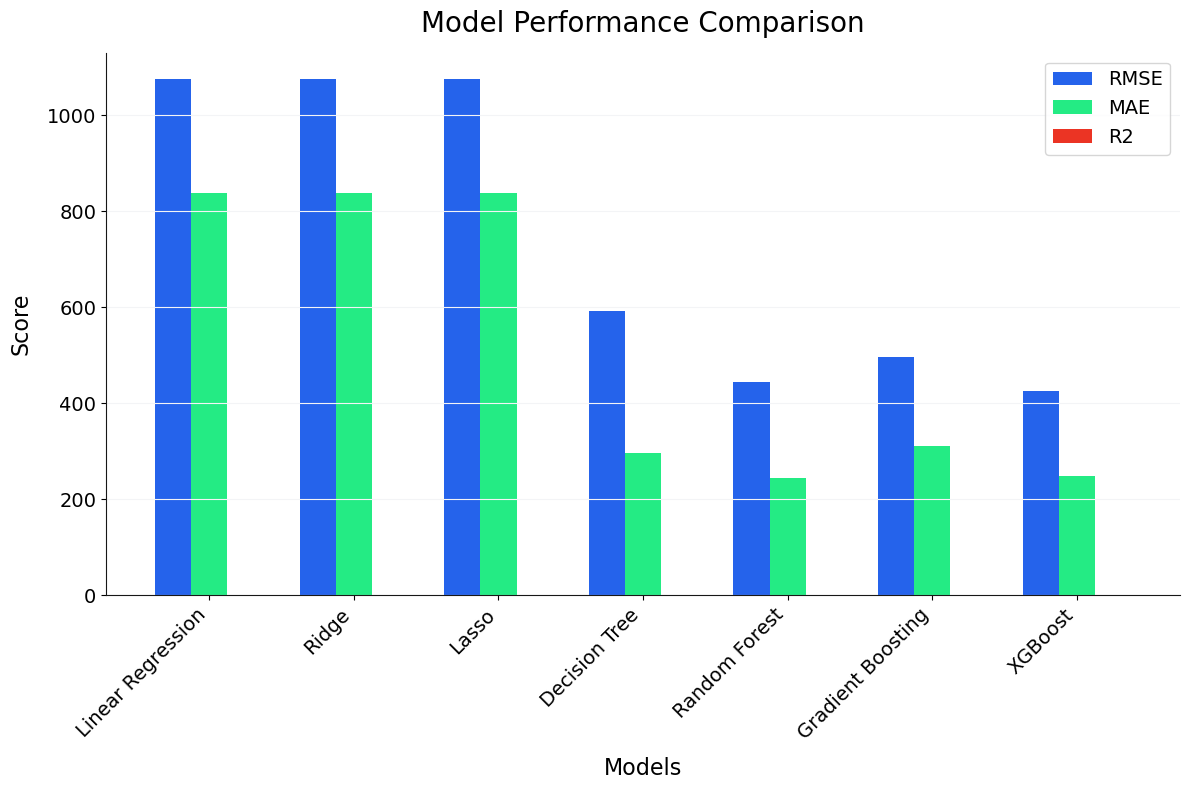

In [92]:
plt.figure(figsize=(12, 8))  
x_axis = np.arange(len(results))  
width = 0.25  
   
plt.bar(x_axis - width, [results[model]['RMSE'] for model in models.keys()],  
         width, label='RMSE', color='#2563EB')  
plt.bar(x_axis, [results[model]['MAE'] for model in models.keys()],  
         width, label='MAE', color='#24EB84')  
plt.bar(x_axis + width, [results[model]['R2'] for model in models.keys()],  
         width, label='R2', color='#EB3424')  
   
plt.xlabel('Models', fontsize=16, labelpad=10)  
plt.ylabel('Score', fontsize=16, labelpad=10)  
plt.title('Model Performance Comparison', fontsize=20, pad=15)  
plt.xticks(x_axis, list(models.keys()), rotation=45, ha='right', fontsize=14)  
plt.yticks(fontsize=14)  
plt.legend(fontsize=14)  
plt.grid(axis='y', color='#F3F4F6')  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.gca().spines['left'].set_color('#171717')  
plt.gca().spines['bottom'].set_color('#171717')  
plt.tight_layout()  
plt.show()  

# Print the best models based on RMSE and R2  

In [95]:
print("\nBest model based on RMSE:", results_df['RMSE'].idxmin())  
print("Best model based on R2:", results_df['R2'].idxmax())  


Best model based on RMSE: XGBoost
Best model based on R2: XGBoost
